In [1]:
import os 
import sys
import glob
from tqdm import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import MDAnalysis as mda
from MDAnalysis.analysis import distances
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import align

In [2]:
%run ~/.mpl_set.py

In [7]:
# ref_pdb = '../../md_runs/omm_runs_protein_1605655756/prot.pdb'
runs = sorted(glob.glob('../../MD_exps/omm_runs_hybrid*'))
runs += ['../../MD_exps/omm_runs_protein_1605383730']

In [8]:
runs

['../../MD_exps/omm_runs_hybrid1_1605383729',
 '../../MD_exps/omm_runs_hybrid2_1605383731',
 '../../MD_exps/omm_runs_hybrid3_1605383731',
 '../../MD_exps/omm_runs_hybrid4_1605383731',
 '../../MD_exps/omm_runs_hybrid5_1605383730',
 '../../MD_exps/omm_runs_hybrid6_1605383729',
 '../../MD_exps/omm_runs_hybrid7_1605383730',
 '../../MD_exps/omm_runs_hybrid8_1605383731',
 '../../MD_exps/omm_runs_protein_1605383730']

In [9]:
rmsf_profs = [] 

for run in runs: 
    run_label = os.path.basename(run).split('_')[2]
    
    if run_label == 'protein': 
        pdb_file = run + '/prot.pdb'
    else: 
        pdb_file = run + '/comp.pdb' 
    traj_file = run + '/output.dcd' 
    
    u = mda.Universe(pdb_file, traj_file) 
    protein = u.select_atoms("protein")
    if run_label == "pep": 
        n_oxt = np.where(protein.atoms.names == 'OXT')[0]
        protein = protein.atoms[:n_oxt[0]+1]
    
    # prealign for average structure
    prealigner = align.AlignTraj(u, u, select="protein and name CA", in_memory=True).run()
    # average 
    reference_coordinates = u.trajectory.timeseries(asel=protein).mean(axis=1)
    # make a reference structure (need to reshape into a 1-frame "trajectory")
    reference = mda.Merge(protein).load_new(
                reference_coordinates[:, None, :], order="afc")
    aligner = align.AlignTraj(u, reference, select="protein and name CA", in_memory=True).run()
    
    calphas = protein.select_atoms("name CA")
    rmsfer = RMSF(calphas, verbose=True).run()
    
    rmsf_profs.append({"name": run_label, "rmsf": rmsfer.rmsf})

Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]
Step  4000/4000 [100.0%]


In [10]:
df = pd.DataFrame(rmsf_profs)
df

,name,rmsf
0,hybrid1,"[7.765813188322112, 5.738679367710996, 3.06848..."
1,hybrid2,"[5.1525520242601095, 3.2861386526737766, 2.021..."
2,hybrid3,"[6.862351431847554, 5.077665286278023, 3.09636..."
3,hybrid4,"[4.5087594344899635, 3.0858678442203993, 1.939..."
4,hybrid5,"[5.777615870566083, 3.497530567906336, 2.12772..."
5,hybrid6,"[4.322978058096361, 2.7126987037345067, 1.5654..."
6,hybrid7,"[6.518019823726452, 4.151749498228986, 2.59517..."
7,hybrid8,"[5.199657453169716, 3.4639736242622017, 2.1308..."
8,protein,"[4.85439977697157, 3.6637682580671447, 3.27677..."


Text(0, 0.5, 'RMSF ($\\AA$)')

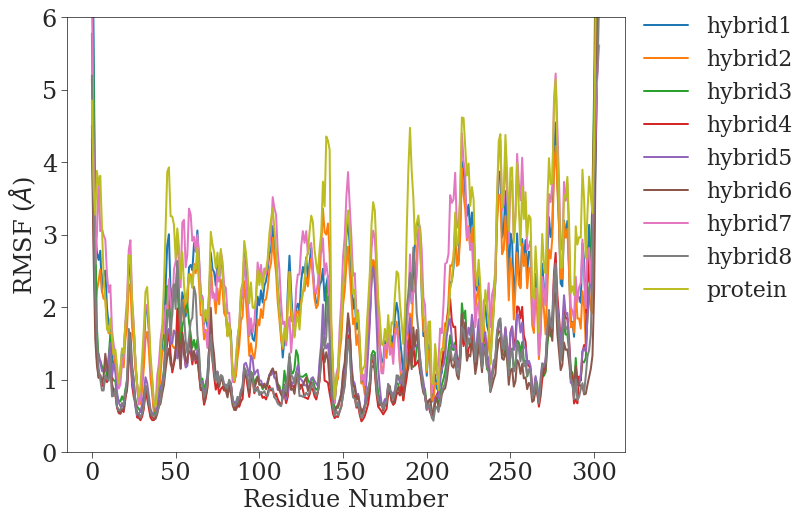

In [14]:
fig, ax = plt.subplots(figsize=(10, 8)) 

for index, row in df.iterrows(): 
    ax.plot(row['rmsf'], label=row['name'])
ax.legend(bbox_to_anchor=(1.0, 1.05))
ax.set_ylim([0, 6])
ax.set_xlabel("Residue Number")
ax.set_ylabel(r"RMSF ($\AA$)")

In [12]:
np.save('rmsf.npy', rmsf_profs) 